In [1]:
import quantumpropagator as qp
import matplotlib.pyplot as plt
from ipywidgets import interact,fixed #, interactive, fixed, interact_manual
import ipywidgets as widgets
#%matplotlib notebook
%matplotlib ipympl

plt.rcParams.update({'font.size': 8})

# Single pulse graph

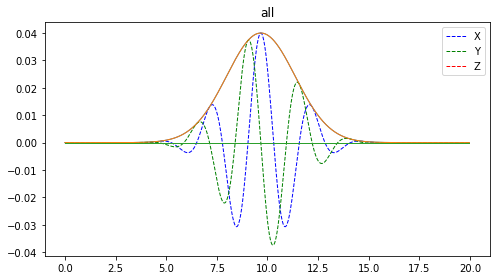

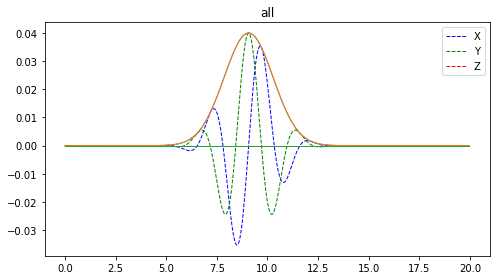

In [2]:
def graph_single(pulseX,pulseY,pulseZ, fs, reso):
    pulses = [pulseX,pulseY,pulseZ]

    # actual plotting array
    fsarray = (np.arange(fs*reso))/reso
    a = qp.fromFsToAu(fsarray)
    bx, by, bz = [ qp.pulZe(a,this_pulse) for this_pulse in pulses ] 
    cx, cy, cz = [ qp.envel(a,this_pulse[0],this_pulse[2],this_pulse[4]) for this_pulse in pulses ]

    #fig, [[ax0, ax1],[ax2,ax3]] = plt.subplots(2,2,figsize=(14,8),sharey=True,sharex=True)
    fig, ax0 = plt.subplots(1,1,figsize=(7,4))

    ax0.plot(fsarray,bx,ls='--', lw=1, label='X', color='b')
    ax0.plot(fsarray,cx, lw=1)
    ax0.plot(fsarray,by,ls='--', lw=1, label='Y', color='g')
    ax0.plot(fsarray,cy, lw=1)
    ax0.plot(fsarray,bz,ls='--', lw=1, label='Z', color='r')
    ax0.plot(fsarray,cz, lw=1)
    ax0.set_title('all')
    ax0.legend()

#     ax1.plot(fsarray,bx, color='b')
#     ax1.plot(fsarray,cx)
#     ax1.set_title('X')
    
#     ax2.plot(fsarray,by, color='g')
#     ax2.plot(fsarray,cy)
#     ax2.set_title('Y')

#     ax3.plot(fsarray,bz, color='r')
#     ax3.plot(fsarray,cz)
#     ax3.set_title('Z')


    fig.tight_layout();
    
pulseX = [0.04,0.06,70,0,400]
pulseY = [0.04,0.06,70,1.570796,400] 
pulseZ = [0,0,0,0,0]

# good one

pulseX2 = [0.04,0.06,50,-1.570796,375]
pulseY2 = [0.04,0.06,50,0,375]
pulseZ2 = [0,0,0,0,0]

# graph length in fs
fs = 20
# graph resolution
reso = 40

graph_single(pulseX,pulseY,pulseZ,fs,reso)
graph_single(pulseX2,pulseY2,pulseZ2,fs,reso)

(800,)


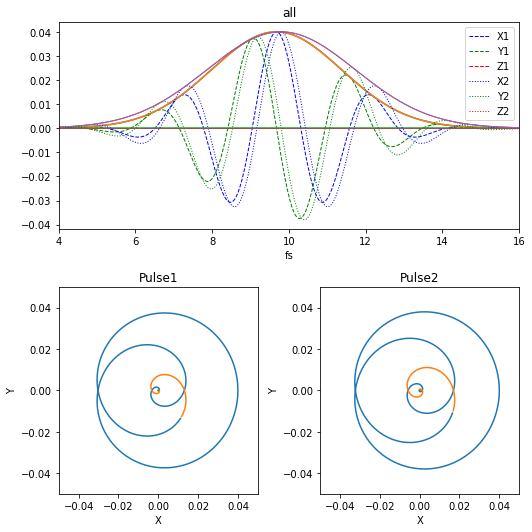

In [3]:
def graph_double(pulseX1,pulseY1,pulseZ1,pulseX2,pulseY2,pulseZ2, fs, reso):
    pulses1 = [pulseX1,pulseY1,pulseZ1]
    pulses2 = [pulseX2,pulseY2,pulseZ2]

    # actual plotting array
    fsarray = (np.arange(fs*reso))/reso
    
    a = qp.fromFsToAu(fsarray)
    bx1, by1, bz1 = [ qp.pulZe(a,this_pulse) for this_pulse in pulses1 ] 
    cx1, cy1, cz1 = [ qp.envel(a,this_pulse[0],this_pulse[2],this_pulse[4]) for this_pulse in pulses1 ]
    bx2, by2, bz2 = [ qp.pulZe(a,this_pulse) for this_pulse in pulses2 ] 
    cx2, cy2, cz2 = [ qp.envel(a,this_pulse[0],this_pulse[2],this_pulse[4]) for this_pulse in pulses2 ]
    print(bx1.shape)
    #fig, [[ax0, ax1],[ax2,ax3]] = plt.subplots(2,2,figsize=(14,8),sharey=True,sharex=True)
    fig, [[ax0,ax1],[ax2,ax3]] = plt.subplots(2,2,figsize=(7.5,7.5))
    
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    
    ax0.plot(fsarray,bx1,ls='--', lw=1, label='X1', color='b')
    ax0.plot(fsarray,cx1, lw=1.5)
    ax0.plot(fsarray,by1,ls='--', lw=1, label='Y1', color='g')
    ax0.plot(fsarray,cy1, lw=1.5)
    ax0.plot(fsarray,bz1,ls='--', lw=1, label='Z1', color='r')
    ax0.plot(fsarray,cz1, lw=1.5)
    ax0.plot(fsarray,bx2,ls=':', lw=1, label='X2', color='b')
    ax0.plot(fsarray,cx2, lw=1)
    ax0.plot(fsarray,by2,ls=':', lw=1, label='Y2', color='g')
    ax0.plot(fsarray,cy2, lw=1)
    ax0.plot(fsarray,bz2,ls=':', lw=1, label='Z2', color='r')
    ax0.plot(fsarray,cz2, lw=1)
    ax0.set_title('all')
    ax0.set_xlabel('fs')
    ax0.set_xlim(4,16)
    ax0.legend()
    
    ax2.set_xlim(-0.05,0.05)
    ax2.set_ylim(-0.05,0.05)

    bond1 = 100
    bond2 = 300
    
    ax2.plot(bx1[bond2:],      by1[bond2:])
    ax2.plot(bx1[bond1:bond2], by1[bond1:bond2])
    ax2.plot(bx1[:bond1],      by1[:bond1])
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Pulse1')
    
    ax3.set_xlim(-0.05,0.05)
    ax3.set_ylim(-0.05,0.05)
    
    ax3.plot(bx2[bond2:],      by2[bond2:])
    ax3.plot(bx2[bond1:bond2], by2[bond1:bond2])
    ax3.plot(bx2[:bond1],      by2[:bond1])
    ax3.set_title('Pulse2')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    
    fig.tight_layout();
    
pulseX1 = [0.04,0.06,70.11,0,400]
pulseY1 = [0.04,0.06,70.11,1.570796,400] 
pulseZ1 = [0,0,0,0,0]

# good one
pulseX2 = [0.04,0.06,80,0,405]
pulseY2 = [0.04,0.06,80,1.570796,405]
pulseZ2 = [0,0,0,0,0]

# graph length in fs
fs = 20
# graph resolution
reso = 40

graph_double(pulseX1,pulseY1,pulseZ1,pulseX2,pulseY2,pulseZ2, fs, reso)

In [4]:
# Altri pulses che ho lanciato

# pulseX2 = [0.04,0.06,140,0,600]
# pulseY2 = [0.04,0.06,140,1.570796,600]
# pulseZ2 = [0,0,0,0,0]


# pulseX2 = [0.04,0.06,90,1.570796,425]
# pulseY2 = [0.04,0.06,90,1.570796*2,425]
# pulseZ2 = [0,0,0,0,0]


In [5]:
name_data_file = '/home/alessio/NAC_smoothing/LESSMASS/2019-May-smoothNacONLY.pickle'

dataDict = qp.pickleLoad(name_data_file)
print('Pickle loaded')

dataDict.keys()

Pickle loaded


dict_keys(['dipCUBE', 'kinCube', 'smoCube', 'thes', 'potCube', 'gams', 'phis', 'geoCUBE'])

In [6]:
# def expARR(array,howmany,direction=None):
#     direction = direction or 'both'
#     dx = array[1]-array[0]
#     after = (array[-1] + (dx * np.arange(howmany+1)))[1:]
#     before = np.flip((array[0] - (dx * np.arange(howmany+1)))[1:],0)
#     if direction == 'both':
#         return np.concatenate((before,array,after))
#     elif direction == 'dx':
#         return np.concatenate((array,after))
#     elif direction == 'sx':
#         return np.concatenate((before,array))

pot = dataDict['potCube']

print(qp.find_numpy_index_minumum(pot))
pmin, gmin, tmin, smin = qp.find_numpy_index_minumum(pot)

phiV, gamV, theV = qp.fromLabelsToFloats(dataDict)

phis = qp.labTranformA(dataDict['phis'])
gams = qp.labTranformA(dataDict['gams'])
thes = qp.labTranformA(dataDict['thes'])

phiL = len(phis)
gamL = len(gams)
theL = len(thes)

(29, 28, 55, 0)


In [7]:
def graphichetto(pulseXX, label, phi_slice, gam_slice, save=None, internal_coord=None):
    save = save or False
    internal_coord = internal_coord or False
    
    sigma = pulseXX[2]
    omega = pulseXX[1]

    # I will cut the cube at phi_min and gamma_min
    pot_cut = pot[phi_slice,gam_slice]
    nstates = 8
    
    # create labels
    thes = qp.labTranformA(dataDict['thes'])
    
    
    # create the 4 panels
    fig, ([ax, ax0], [ax1, ax2]) = plt.subplots(2,2, gridspec_kw = {'height_ratios':[3, 1], 'width_ratios':[3, 1]},figsize=(15,10))
    ax2.axis('off')
    

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'mediumpurple']
    for iii in range(nstates):
        if internal_coord:
            ax.plot(thes, pot_cut[:,iii], ls='-', lw=1.5, color=colors[iii]);
            ax.set_ylabel('Potential Energy (Hartree)')
        else:
            ax.plot(thes, qp.fromHartoEv(pot_cut[:,iii]), ls='-', lw=1.5, color=colors[iii]);
            ax.set_ylabel('Potential Energy (eV)')

    ax.set_xlabel('q')
    ax.set_ylabel('Potential Energy')

    # fs extent of GRAPH
    fs = 100
    # resolution of graph
    reso = 20
    
    # actaual values for the pulse
    fsarray = (np.arange(fs*reso))/reso
    
    # I need the fsarray in AU to call the internal functions pulZe and envel
    a = qp.fromFsToAu(fsarray)
    f = qp.pulZe(a,pulseXX)
    title_thing = r'AU -> $E$={:5.2f}  $\omega$={:6.3f}  $\sigma$={:6.3f}  $\phi$={:6.3f}  $t_0$={:5.2f}'.format(pulseXX[0],pulseXX[1],pulseXX[2],pulseXX[3],pulseXX[4])
    ax.set_title(title_thing)
    c = qp.envel(a,pulseXX[0],pulseXX[2],pulseXX[4])


    # but then I plot on femtoseconds
    if internal_coord:
        ax1.plot(a,f)
        ax1.plot(a,c)
        ax1.set_xlabel('Time (AU)')        
    else:
        ax1.plot(fsarray,f)
        ax1.plot(fsarray,c)
        ax1.set_xlabel('Time (fs)')
    
    # labels
    ax.set_xlabel(r'$\theta$ (rad)')

    # sigma in energy space
  
    e = 1/(sigma)
    #e = 2*np.pi/(sigma)
    #e = (np.pi**2)*sigma**2
    #e = 1/(2 * np.pi*(sigma))
    print('e = {}'.format(e))
    
    # the 67% is sigma
    # the 95% interval is 2 sigma. This is why e*2
    # first and second are still in hartree.
    
    first_half = pulseXX[1] - (e *np.sqrt(2*(np.log(2))))
    second_half = pulseXX[1] + (e *np.sqrt(2*(np.log(2))))

    first = pulseXX[1] - (e)
    second = pulseXX[1] + (e)
    first2 = pulseXX[1] - (2*e)
    second2 = pulseXX[1] + (2*e)

    # grey band
    if internal_coord:
        #ax.fill_between(thes, first2, second2, color='whitesmoke')
        ax.fill_between(thes, first_half, second_half, color='gainsboro') # grey bar
        #ax.plot([xmin, xmin], [first_half, second_half], 'k-', lw=2) # black line
    else:
        #ax.fill_between(thes, qp.fromHartoEv(first2), qp.fromHartoEv(second2), color='whitesmoke')
        ax.fill_between(thes, qp.fromHartoEv(first_half), qp.fromHartoEv(second_half), color='gainsboro')
        #ax.plot([xmin, xmin], [qp.fromHartoEv(first_half),qp.fromHartoEv(second_half)], 'k-', lw=2)
    
    ax.set_ylim(0,10)
    maxValue_in_ev = np.amax(pot)
    w = np.linspace(0,maxValue_in_ev,800)

    # This is the other gaussian in reciprocal space.
    e = 1/(sigma)
    other = np.exp(-(w-omega)**2 / (2 * e**2))
    
    #    other = np.exp(-(w-omega)**2 * e)
    
    if internal_coord:
        ax0.plot(other,w)
    else:
        ax0.plot(qp.fromHartoEv(other),qp.fromHartoEv(w))
    
    ax0.set_xticks([])
    ax0.set_ylim(0,10)
    #fig.tight_layout()
    
    if save:
        name_fig = 'pulse{:04d}.png'.format(label)
        fig.savefig(name_fig, dpi=300)

# i = 0
# pulseXX = [0.04,0.23,60,0,2000]
# graphichetto(pulseXX, i, 29, 28)

In [13]:
number = 2*np.sqrt(2*(np.log(2)))
def graphichetto_handler(inter,saves,phi_cut,gam_cut,sigma_OUT,omega_OUT):
    i = 0
    FWMH = 6 #full Width at mid height
    sigmaFS = FWMH/(number) # sigma in FS - the 95% of the gaussian is 4 sigma
    sigma = qp.fromFsToAu(sigmaFS) # sigma is AU
    omega = 1.54980/27.211
    #pulseXX = [0.04,0.23,50,np.pi/2,2000]
    pulseXX = [0.04,omega_OUT,sigma_OUT,np.pi/2,700]
    graphichetto(pulseXX, i, phi_cut, gam_cut, save=saves, internal_coord=inter)

interact(graphichetto_handler,
         inter = widgets.Checkbox(value=False, description='Atomic Units'),
         saves = widgets.Checkbox(value=False, description='save images'),
         phi_cut = widgets.IntSlider(min=0,max=phis.size-1,step=1,value=pmin,continuous_update=False),
         gam_cut = widgets.IntSlider(min=0,max=gams.size-1,step=1,value=gmin,continuous_update=False),
         sigma_OUT = widgets.FloatText(value=100, description='sigma:', disabled=False),
         omega_OUT = widgets.FloatText(value=0.22, description='omega:', disabled=False),
        );

interactive(children=(Checkbox(value=False, description='Atomic Units'), Checkbox(value=False, description='sa…

In [14]:
full_width_half_maximum = (2*np.pi/(2.355*35.11))*27.21
centered_at = 0.22*27.21
full_width_half_maximum,centered_at

(2.0676959124324044, 5.9862)

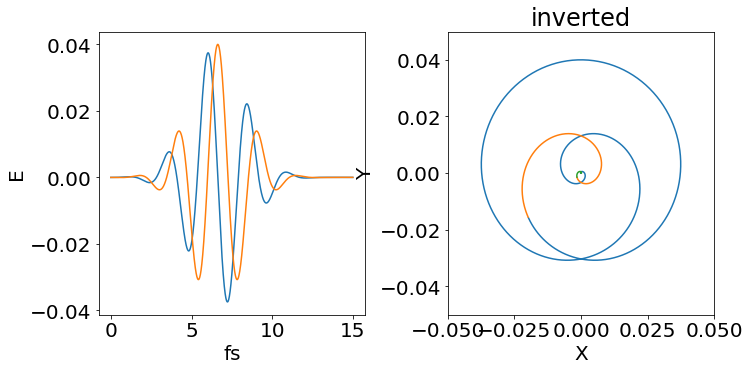

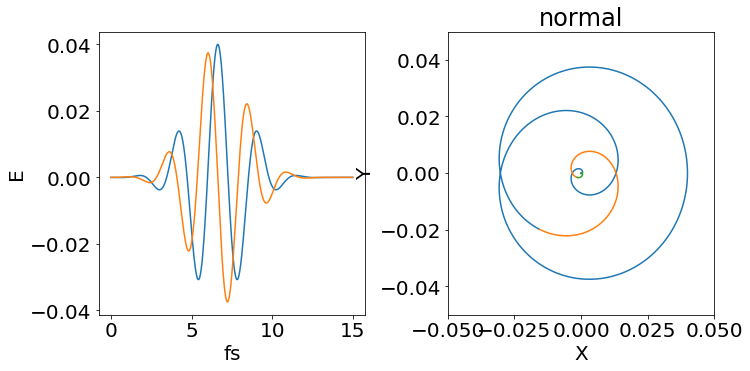

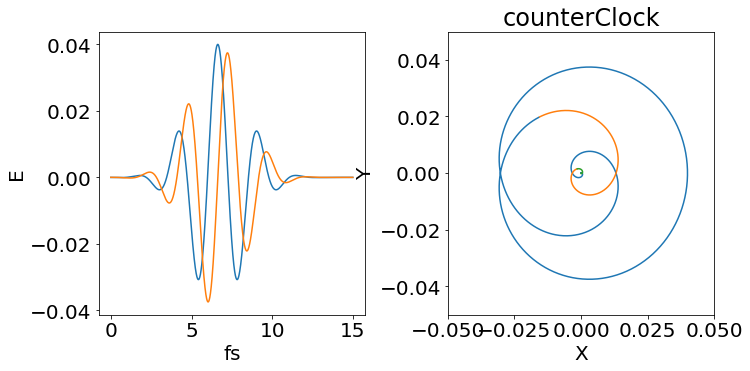

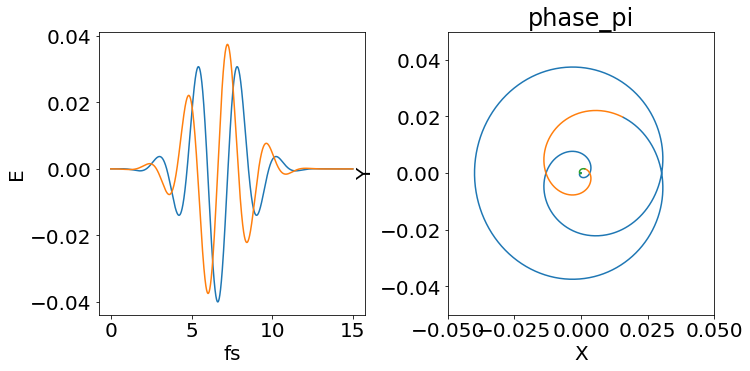

In [16]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


def phaseGraph(pulse3_tuple,fs,reso,first,second,labeol):
    '''
    draw a x on y graph
    '''
    x,y = pulse3_tuple[first],pulse3_tuple[second]
    
    names = ['X','Y','Z']
    
    name_first,name_second = names[first], names[second]

    # actaual values for the pulse
    fsarray = (np.arange(fs*reso))/reso
    
    # I need the fsarray in AU to call the internal functions pulZe and envel
    a = qp.fromFsToAu(fsarray)
    b = qp.pulZe(a,x)        
    c = qp.pulZe(a,y) 
    
    fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,5))
    fig.tight_layout()


    plt.title(labeol)
    
    ax0.set_xlabel('fs')
    ax0.set_ylabel('E')
    ax1.set_xlabel(name_first)
    ax1.set_ylabel(name_second)
    
    ax0.plot(fsarray,b)
    ax0.plot(fsarray,c)
    
    ax1.set_xlim(-0.05,0.05)
    ax1.set_ylim(-0.05,0.05)

    bond1 = 500
    bond2 = 1000
    
    ax1.plot(b[bond2:],c[bond2:])
    ax1.plot(b[bond1:bond2],c[bond1:bond2])
    ax1.plot(b[:bond1],c[:bond1])

def gimme_phases(phi1,phi2):
    '''
    given the two phases, returns a z_dummy IR pulse with different phases to feed the graph
    '''
    pulsino = [[0.04,0.06,70.22,phi1,274],[0.04,0.06,70.22,phi2,274],[1,1,1,1,1]] 
    return pulsino


pulseWant = gimme_phases(np.pi/4,-np.pi/4)

pulse1 = gimme_phases(np.pi/2,0)
pulse2 = gimme_phases(0,np.pi/2)
pulse3 = gimme_phases(0,3*(np.pi/2))
pulse4 = gimme_phases(np.pi,3*(np.pi/2))

phaseGraph(pulse1,15,200,0,1, 'inverted')
phaseGraph(pulse2,15,200,0,1, 'normal')
phaseGraph(pulse3,15,200,0,1, 'counterClock')
phaseGraph(pulse4,15,200,0,1, 'phase_pi')


# New kind of Pulse

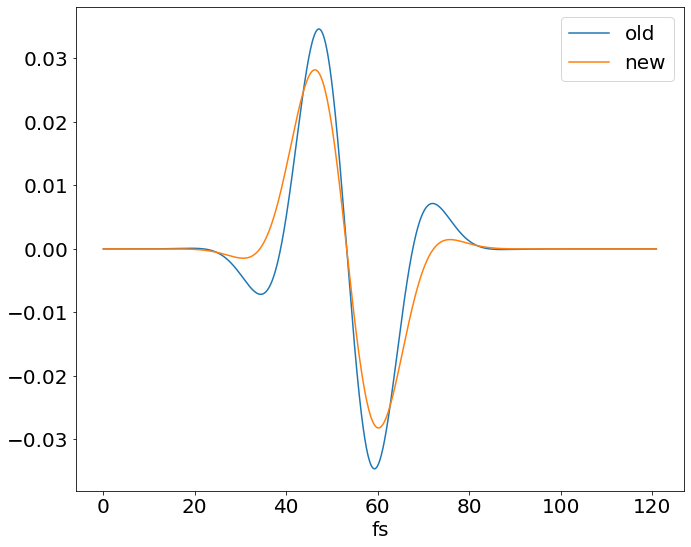

In [17]:
def new_pulse(t,Ed,omega,sigma,phi,t0):
    num = (t-t0)**2
    den = 2*(sigma**2)

    if (den == 0): 
        result = 0.0 
    else:
        num2 = np.sin(omega*(t-t0) + phi) * (t-t0)
        den2 = omega * sigma**2
        result = Ed *  np.exp(-num/den)* (np.cos(omega*(t-t0) + phi) - num2/den2 )
    return result    



times = np.linspace(0,5000,3000)


pul = new_pulse(times,  0.04,0.004,400,np.pi/2,2200)
pil2 = qp.pulZe(times, [0.04,0.004,400,np.pi/2,2200])

fig, ax0 = plt.subplots(1,1,figsize = (10,8))

ax0.plot(qp.fromAuToFs(times), pul, label = 'old')
ax0.plot(qp.fromAuToFs(times), pil2, label = 'new')

ax0.set_xlabel('fs')
ax0.legend()
fig.tight_layout()
